In [1]:
import pandas as pd 
from pandas_profiling import ProfileReport

import numpy as np
import tensorflow as tf
from tensorflow import feature_column
import random as rn
from tqdm import tqdm_notebook


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from utils.data import make_input_fn, categorical_dicts, convert_categorical, breakdown_metrics
from utils.plot import plot_confusion_matrix, plot_breakdown_confusion_matrix
from utils.fairness_metrics import statistical_parity_difference, equality_of_opportunity

from models.arch import make_discriminator_model, make_predictor_model
from models.simple_model import SimpleClassifier
from models.adversarial_model import FairClassifier, Discriminator

### Utility functions

In [2]:
tf.random.set_seed(42)
np.random.seed(42)
rn.seed(42)

### Data Processing

In [3]:
column_list = ['age', 
               'workclass', 
               'fnlwgt', 
               'education', 
               'education_num', 
               'marital_status', 
               'occupation',
               'relationship',
               'race',
               'sex',
               'capital_gain',
               'capital_loss',
               'hours_per_week',
               'native_country',
               'income'
              ]
data = pd.read_csv("./data/adult.data", names=column_list)

In [4]:
# binarizing label
data['income'] = data.income == ' >50K'
data.income = data.income.astype(int)

# dropping unnecessary columns
data = data.drop(['fnlwgt'], axis=1)

categorical_columns = ['education', 'marital_status', 
                       'native_country', 'occupation', 'race', 
                       'relationship', 'sex', 'workclass']

numeric_columns = ['capital_gain', 'capital_loss', 'education_num', 'hours_per_week']

for col in categorical_columns:
    data[col] = data[col].str.replace("^\s+",  "", regex=True)
    
data.loc[data['race'] != 'White', 'race'] = 'Non-White'

In [5]:
data.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Non-White,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Non-White,Female,0,0,40,Cuba,0


In [6]:
data.income.value_counts()

0    24720
1     7841
Name: income, dtype: int64

In [7]:
# profile = ProfileReport(data, title='Census Profiling Report', html={'style':{'full_width':True}})
# profile.to_file(output_file="census_report.html")

### Model Training

In [8]:
train, test = train_test_split(data, test_size=0.5)
train_label, test_label = np.expand_dims(train.pop("income").values, axis=1), np.expand_dims(test.pop("income").values, axis=1)
print(len(train), 'train examples')
print(len(test), 'test examples')
print(test_label.shape)

16280 train examples
16281 test examples
(16281, 1)


In [9]:
scaler =  StandardScaler()

In [10]:
train.loc[:, numeric_columns] = scaler.fit_transform(np.array(train[numeric_columns])) 

/home/cryptexis/dev/anaconda2/envs/dev-env3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [11]:
test.loc[:, numeric_columns] = scaler.transform(np.array(test[numeric_columns]))

/home/cryptexis/dev/anaconda2/envs/dev-env3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [12]:
test.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
14160,27,Private,Some-college,-0.035057,Divorced,Adm-clerical,Not-in-family,White,Female,-0.146662,-0.225446,-0.199828,United-States
27048,45,State-gov,HS-grad,-0.425702,Married-civ-spouse,Exec-managerial,Wife,White,Female,-0.146662,-0.225446,-0.037953,United-States
28868,29,Private,Bachelors,1.136877,Married-civ-spouse,Exec-managerial,Husband,Non-White,Male,-0.146662,-0.225446,1.176107,United-States
5667,30,Private,Bachelors,1.136877,Never-married,Machine-op-inspct,Not-in-family,White,Female,-0.146662,-0.225446,-0.037953,United-States
7827,29,Self-emp-not-inc,Some-college,-0.035057,Divorced,Craft-repair,Not-in-family,White,Male,0.166019,-0.225446,0.771420,United-States


In [13]:
batch_size = 128 # A small batch sized is used for demonstration purposes
train_ds = make_input_fn(train,  train_label, batch_size=batch_size, shuffle=True)
test_ds = make_input_fn(test, test_label,  shuffle=False, batch_size=batch_size)

In [14]:
feature_columns = []

age = feature_column.numeric_column("age")
age_buckets = feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

# processing categorical columns
cat_maps  = categorical_dicts(data, categorical_columns)

for col in categorical_columns:
    col_one_hot = convert_categorical(col, cat_maps)
    feature_columns.append(col_one_hot)

# processing numeric columns
for col in numeric_columns:
    feature_columns.append(feature_column.numeric_column(col))

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [15]:
p_model = make_predictor_model(feature_layer)
clf = SimpleClassifier(p_model)
clf.train(train_dataset = train_ds(), 
           epochs = 10, 
           validation_dataset = test_ds())

0it [00:00, ?it/s]

Epoch: 0
Training:
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


128it [00:01, 85.37it/s]
0it [00:00, ?it/s]

Mean: 0.626141369342804, TruePositives: 1551.0, FalsePositives: 3245.0, TrueNegatives: 9119.0, FalseNegatives: 2365.0, BinaryAccuracy: 0.6554054021835327
------------------------------------------------------

Validation:

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



128it [00:01, 120.11it/s]
2it [00:00, 19.59it/s]

Mean: 0.29209327697753906, TruePositives: 945.0, FalsePositives: 498.0, TrueNegatives: 11858.0, FalseNegatives: 2980.0, BinaryAccuracy: 0.7863767743110657
------------------------------------------------------

Epoch: 1
Training:


128it [00:00, 150.92it/s]
16it [00:00, 155.50it/s]

Mean: 0.47586509585380554, TruePositives: 974.0, FalsePositives: 302.0, TrueNegatives: 12062.0, FalseNegatives: 2942.0, BinaryAccuracy: 0.8007370829582214
------------------------------------------------------

Validation:


128it [00:00, 164.21it/s]
2it [00:00, 19.51it/s]

Mean: 0.3587149381637573, TruePositives: 1221.0, FalsePositives: 321.0, TrueNegatives: 12035.0, FalseNegatives: 2704.0, BinaryAccuracy: 0.8142005801200867
------------------------------------------------------

Epoch: 2
Training:


128it [00:00, 147.07it/s]
17it [00:00, 161.38it/s]

Mean: 0.41545361280441284, TruePositives: 1353.0, FalsePositives: 346.0, TrueNegatives: 12018.0, FalseNegatives: 2563.0, BinaryAccuracy: 0.8213145136833191
------------------------------------------------------

Validation:


128it [00:00, 165.44it/s]
3it [00:00, 28.64it/s]

Mean: 0.4091666042804718, TruePositives: 1501.0, FalsePositives: 398.0, TrueNegatives: 11958.0, FalseNegatives: 2424.0, BinaryAccuracy: 0.8266690969467163
------------------------------------------------------

Epoch: 3
Training:


128it [00:00, 152.85it/s]
17it [00:00, 164.76it/s]

Mean: 0.38389888405799866, TruePositives: 1606.0, FalsePositives: 454.0, TrueNegatives: 11910.0, FalseNegatives: 2310.0, BinaryAccuracy: 0.8302211165428162
------------------------------------------------------

Validation:


128it [00:00, 174.83it/s]
2it [00:00, 19.78it/s]

Mean: 0.4447060227394104, TruePositives: 1698.0, FalsePositives: 484.0, TrueNegatives: 11872.0, FalseNegatives: 2227.0, BinaryAccuracy: 0.8334869146347046
------------------------------------------------------

Epoch: 4
Training:


128it [00:00, 155.01it/s]
17it [00:00, 166.89it/s]

Mean: 0.36636847257614136, TruePositives: 1776.0, FalsePositives: 511.0, TrueNegatives: 11853.0, FalseNegatives: 2140.0, BinaryAccuracy: 0.8371621370315552
------------------------------------------------------

Validation:


128it [00:00, 173.44it/s]
3it [00:00, 28.85it/s]

Mean: 0.46964138746261597, TruePositives: 1833.0, FalsePositives: 561.0, TrueNegatives: 11795.0, FalseNegatives: 2092.0, BinaryAccuracy: 0.8370493054389954
------------------------------------------------------

Epoch: 5
Training:


128it [00:00, 152.59it/s]
17it [00:00, 163.03it/s]

Mean: 0.35392332077026367, TruePositives: 1941.0, FalsePositives: 600.0, TrueNegatives: 11764.0, FalseNegatives: 1975.0, BinaryAccuracy: 0.8418304920196533
------------------------------------------------------

Validation:


128it [00:00, 174.69it/s]
3it [00:00, 28.95it/s]

Mean: 0.4886408746242523, TruePositives: 1903.0, FalsePositives: 591.0, TrueNegatives: 11765.0, FalseNegatives: 2022.0, BinaryAccuracy: 0.8395061492919922
------------------------------------------------------

Epoch: 6
Training:


128it [00:00, 157.28it/s]
17it [00:00, 168.21it/s]

Mean: 0.34502047300338745, TruePositives: 2024.0, FalsePositives: 632.0, TrueNegatives: 11732.0, FalseNegatives: 1892.0, BinaryAccuracy: 0.8449631333351135
------------------------------------------------------

Validation:


128it [00:00, 176.44it/s]
3it [00:00, 29.30it/s]

Mean: 0.5031465291976929, TruePositives: 1984.0, FalsePositives: 625.0, TrueNegatives: 11731.0, FalseNegatives: 1941.0, BinaryAccuracy: 0.8423929810523987
------------------------------------------------------

Epoch: 7
Training:


128it [00:00, 157.81it/s]
17it [00:00, 169.53it/s]

Mean: 0.3390202224254608, TruePositives: 2055.0, FalsePositives: 659.0, TrueNegatives: 11705.0, FalseNegatives: 1861.0, BinaryAccuracy: 0.8452088236808777
------------------------------------------------------

Validation:


128it [00:00, 178.26it/s]
4it [00:00, 38.01it/s]

Mean: 0.5136796832084656, TruePositives: 2056.0, FalsePositives: 662.0, TrueNegatives: 11694.0, FalseNegatives: 1869.0, BinaryAccuracy: 0.8445427417755127
------------------------------------------------------

Epoch: 8
Training:


128it [00:00, 157.84it/s]
17it [00:00, 167.35it/s]

Mean: 0.3350786864757538, TruePositives: 2108.0, FalsePositives: 695.0, TrueNegatives: 11669.0, FalseNegatives: 1808.0, BinaryAccuracy: 0.8462530970573425
------------------------------------------------------

Validation:


128it [00:00, 175.85it/s]
3it [00:00, 29.47it/s]

Mean: 0.5219700336456299, TruePositives: 2127.0, FalsePositives: 689.0, TrueNegatives: 11667.0, FalseNegatives: 1798.0, BinaryAccuracy: 0.8472452759742737
------------------------------------------------------

Epoch: 9
Training:


128it [00:00, 155.26it/s]
18it [00:00, 170.88it/s]

Mean: 0.3324703872203827, TruePositives: 2138.0, FalsePositives: 698.0, TrueNegatives: 11666.0, FalseNegatives: 1778.0, BinaryAccuracy: 0.847911536693573
------------------------------------------------------

Validation:


128it [00:00, 177.29it/s]

Mean: 0.5287955403327942, TruePositives: 2168.0, FalsePositives: 715.0, TrueNegatives: 11641.0, FalseNegatives: 1757.0, BinaryAccuracy: 0.8481665849685669
------------------------------------------------------



In [16]:
test_evaluation = clf.evaluate(test_ds())

128it [00:00, 176.95it/s]

Mean: 0.5287955403327942, TruePositives: 2168.0, FalsePositives: 715.0, TrueNegatives: 11641.0, FalseNegatives: 1757.0, BinaryAccuracy: 0.8481665849685669
------------------------------------------------------



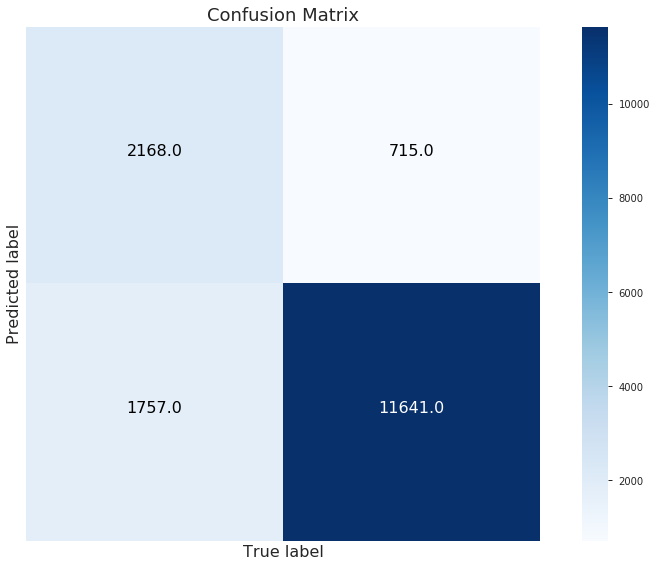

In [17]:
plot_confusion_matrix(cm = np.array([[ test_evaluation[1], test_evaluation[2]],
                                     [ test_evaluation[4], test_evaluation[3]]]), 
                      title = "Confusion Matrix")

### Breakdown Statistics

In [18]:
test_predictions =  clf.predict(test_ds())

test_combined = test.copy() 
test_combined['label'] = test_label
test_combined['predicted'] = test_predictions

128it [00:00, 786.38it/s]


In [19]:
test_combined.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,label,predicted
14160,27,Private,Some-college,-0.035057,Divorced,Adm-clerical,Not-in-family,White,Female,-0.146662,-0.225446,-0.199828,United-States,0,0
27048,45,State-gov,HS-grad,-0.425702,Married-civ-spouse,Exec-managerial,Wife,White,Female,-0.146662,-0.225446,-0.037953,United-States,0,0
28868,29,Private,Bachelors,1.136877,Married-civ-spouse,Exec-managerial,Husband,Non-White,Male,-0.146662,-0.225446,1.176107,United-States,1,1
5667,30,Private,Bachelors,1.136877,Never-married,Machine-op-inspct,Not-in-family,White,Female,-0.146662,-0.225446,-0.037953,United-States,0,0
7827,29,Self-emp-not-inc,Some-college,-0.035057,Divorced,Craft-repair,Not-in-family,White,Male,0.166019,-0.225446,0.771420,United-States,0,0


In [20]:
# selecting sub-dataframes corresponding to True/False positives and True/False negatives
tp = test_combined[(test_combined.label == test_combined.predicted) & (test_combined.label == 1)]
tn = test_combined[(test_combined.label == test_combined.predicted) & (test_combined.label == 0)]
fp = test_combined[(test_combined.label != test_combined.predicted) & (test_combined.label == 0)]
fn = test_combined[(test_combined.label != test_combined.predicted) & (test_combined.label == 1)]

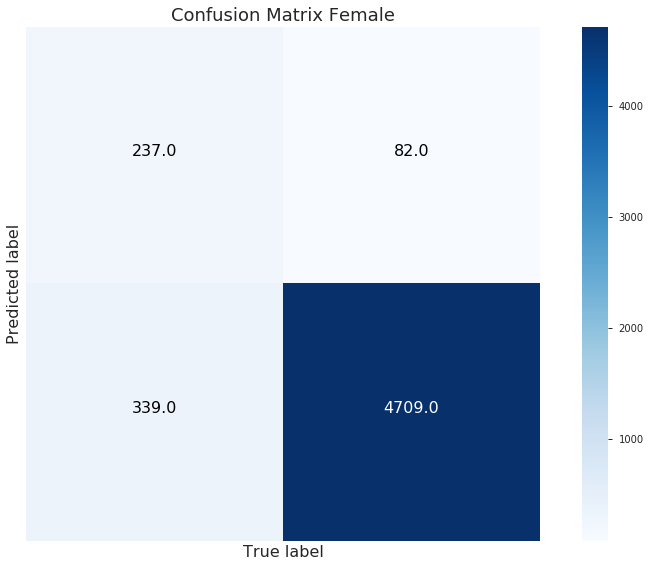

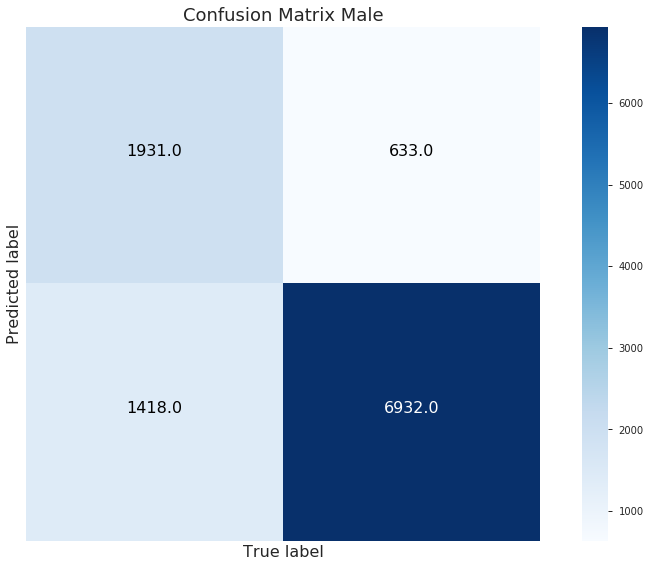

For value Female: FPR: 0.017115424754748487, FNR: 0.5885416666666666
For value Male: FPR: 0.08367481824190351, FNR: 0.42340997312630635


In [21]:
col = 'sex'
for val in  test[col].unique():
    plot_breakdown_confusion_matrix(tp, tn, fp, fn, col, val)
    
for val in test[col].unique():
    breakdown_metrics(tp, tn, fp, fn, col, val)

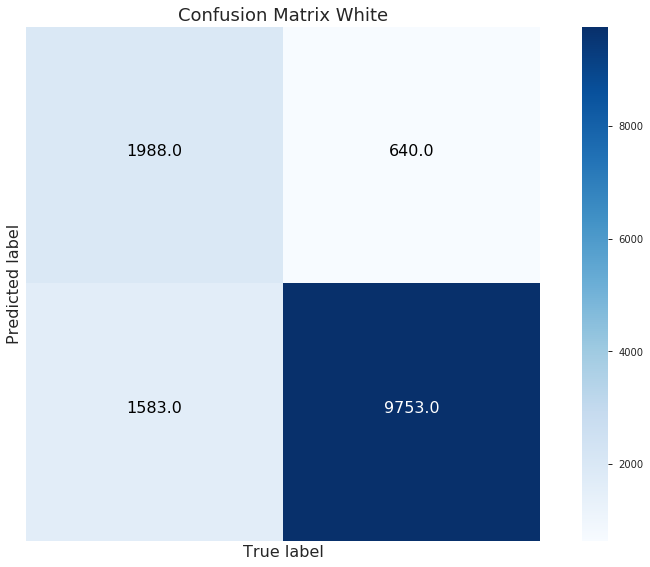

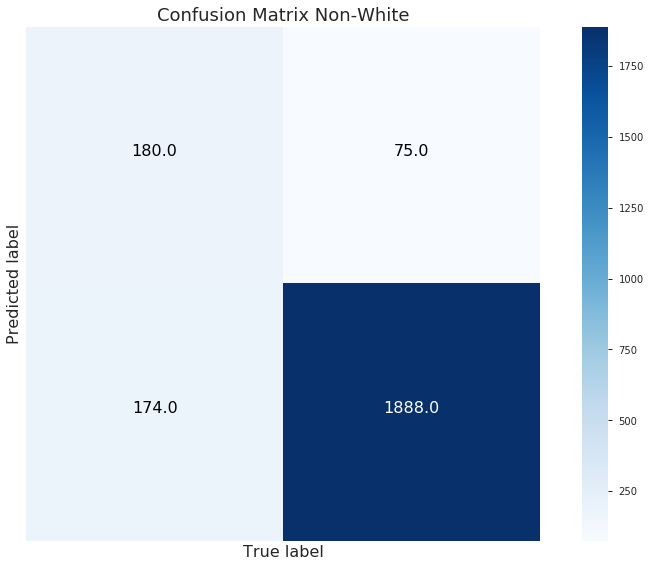

For value White: FPR: 0.061579909554507845, FNR: 0.44329319518342203
For value Non-White: FPR: 0.038206826286296486, FNR: 0.4915254237288136


In [22]:
col = 'race'
for val in  test[col].unique():
    plot_breakdown_confusion_matrix(tp, tn, fp, fn, col, val)
    
for val in test[col].unique():
    breakdown_metrics(tp, tn, fp, fn, col, val)

### Fairness metrics

Privileged Group: Male
Statistical parity P(Y_hat = 1) - P(Y_hat= 1| sex=Female): 0.11764027305659558
Statistical parity P(Y_hat = 1) - P(Y_hat= 1| sex=Male): -0.05785004081865022
Statistical parity P(Y_hat = 1|sex=Male) - P(Y_hat= 1|sex=Female): 0.1754903138752458


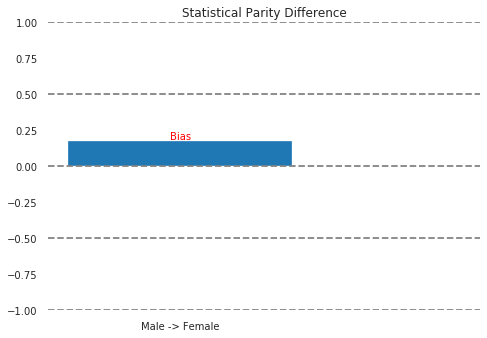

In [23]:
statistical_parity_difference(test_combined, 'predicted', 'sex')

Privileged Group: Male
Opportunity P(Y_hat = 1| Y=1) - P(Y_hat = 1| Y=1, sex=Female): 0.1408983545647559
Opportunity P(Y_hat = 1| Y=1) - P(Y_hat = 1| Y=1, sex=Male): -0.024233338975604424
Statistical parity P(Y_hat = 1| Y=1, sex=Male) - P(Y_hat= 1| Y=1, sex=Female): 0.16513169354036034


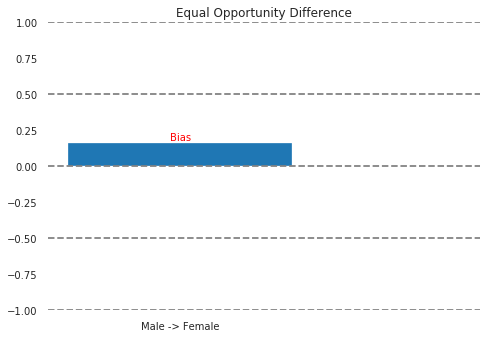

In [24]:
equality_of_opportunity(test_combined, 'predicted', 'label', 'sex')

### Applying adversarial model

In [25]:
tf.random.set_seed(42)
np.random.seed(42)
rn.seed(42)

p_model = make_predictor_model(feature_layer)
d_model = Discriminator(make_discriminator_model(), "sex")
fclf = FairClassifier(p_model, d_model, hyper_parameters={'alpha': 9.3, 'c': 2.0, 'category_maps': cat_maps})
fclf.train(train_dataset = train_ds(), 
           epochs = 10,
           validation_dataset = test_ds())

0it [00:00, ?it/s]

Epoch: 0
Training:
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Mangled names are not yet supported by AutoGraph
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Mangled names are not yet supported by AutoGraph


128it [00:01, 70.13it/s]
1it [00:00,  6.03it/s]

Mean: 0.68841952085495, TruePositives: 912.0, FalsePositives: 3562.0, TrueNegatives: 8802.0, FalseNegatives: 3004.0, BinaryAccuracy: 0.5966830253601074
------------------------------------------------------

Validation:


128it [00:01, 120.81it/s]
1it [00:00,  9.79it/s]

Mean: 0.22492678463459015, TruePositives: 269.0, FalsePositives: 807.0, TrueNegatives: 11549.0, FalseNegatives: 3656.0, BinaryAccuracy: 0.7258768081665039
------------------------------------------------------

Epoch: 1
Training:


128it [00:00, 150.99it/s]
17it [00:00, 168.99it/s]

Mean: 0.5813037157058716, TruePositives: 354.0, FalsePositives: 559.0, TrueNegatives: 11805.0, FalseNegatives: 3562.0, BinaryAccuracy: 0.746867299079895
------------------------------------------------------

Validation:


128it [00:00, 167.43it/s]
1it [00:00,  8.89it/s]

Mean: 0.28096944093704224, TruePositives: 446.0, FalsePositives: 445.0, TrueNegatives: 11911.0, FalseNegatives: 3479.0, BinaryAccuracy: 0.7589828372001648
------------------------------------------------------

Epoch: 2
Training:


128it [00:00, 149.66it/s]
16it [00:00, 159.70it/s]

Mean: 0.510205864906311, TruePositives: 568.0, FalsePositives: 439.0, TrueNegatives: 11925.0, FalseNegatives: 3348.0, BinaryAccuracy: 0.7673832774162292
------------------------------------------------------

Validation:


128it [00:00, 166.61it/s]
1it [00:00,  8.60it/s]

Mean: 0.32212045788764954, TruePositives: 667.0, FalsePositives: 315.0, TrueNegatives: 12041.0, FalseNegatives: 3258.0, BinaryAccuracy: 0.780541718006134
------------------------------------------------------

Epoch: 3
Training:


128it [00:00, 146.08it/s]
16it [00:00, 158.90it/s]

Mean: 0.464505672454834, TruePositives: 903.0, FalsePositives: 477.0, TrueNegatives: 11887.0, FalseNegatives: 3013.0, BinaryAccuracy: 0.7856265306472778
------------------------------------------------------

Validation:


128it [00:00, 167.50it/s]
1it [00:00,  8.84it/s]

Mean: 0.3561599850654602, TruePositives: 1265.0, FalsePositives: 638.0, TrueNegatives: 11718.0, FalseNegatives: 2660.0, BinaryAccuracy: 0.7974326014518738
------------------------------------------------------

Epoch: 4
Training:


128it [00:00, 142.56it/s]
17it [00:00, 166.31it/s]

Mean: 0.4421929717063904, TruePositives: 1517.0, FalsePositives: 794.0, TrueNegatives: 11570.0, FalseNegatives: 2399.0, BinaryAccuracy: 0.8038697838783264
------------------------------------------------------

Validation:


128it [00:00, 171.44it/s]
1it [00:00,  9.50it/s]

Mean: 0.3790394365787506, TruePositives: 1702.0, FalsePositives: 879.0, TrueNegatives: 11477.0, FalseNegatives: 2223.0, BinaryAccuracy: 0.8094711899757385
------------------------------------------------------

Epoch: 5
Training:


128it [00:00, 143.96it/s]
15it [00:00, 147.00it/s]

Mean: 0.4287709593772888, TruePositives: 1756.0, FalsePositives: 904.0, TrueNegatives: 11460.0, FalseNegatives: 2160.0, BinaryAccuracy: 0.8117936253547668
------------------------------------------------------

Validation:


128it [00:00, 155.04it/s]
1it [00:00,  8.75it/s]

Mean: 0.39394068717956543, TruePositives: 1722.0, FalsePositives: 863.0, TrueNegatives: 11493.0, FalseNegatives: 2203.0, BinaryAccuracy: 0.8116823434829712
------------------------------------------------------

Epoch: 6
Training:


128it [00:00, 140.15it/s]
18it [00:00, 172.37it/s]

Mean: 0.41842740774154663, TruePositives: 1761.0, FalsePositives: 869.0, TrueNegatives: 11495.0, FalseNegatives: 2155.0, BinaryAccuracy: 0.8142505884170532
------------------------------------------------------

Validation:


128it [00:00, 173.87it/s]
1it [00:00,  9.70it/s]

Mean: 0.4059399366378784, TruePositives: 1757.0, FalsePositives: 857.0, TrueNegatives: 11499.0, FalseNegatives: 2168.0, BinaryAccuracy: 0.8142005801200867
------------------------------------------------------

Epoch: 7
Training:


128it [00:00, 149.56it/s]
18it [00:00, 171.38it/s]

Mean: 0.4118221402168274, TruePositives: 1790.0, FalsePositives: 859.0, TrueNegatives: 11505.0, FalseNegatives: 2126.0, BinaryAccuracy: 0.8166462182998657
------------------------------------------------------

Validation:


128it [00:00, 174.42it/s]
1it [00:00,  9.33it/s]

Mean: 0.4154638648033142, TruePositives: 1800.0, FalsePositives: 865.0, TrueNegatives: 11491.0, FalseNegatives: 2125.0, BinaryAccuracy: 0.8163503408432007
------------------------------------------------------

Epoch: 8
Training:


128it [00:00, 152.49it/s]
16it [00:00, 159.98it/s]

Mean: 0.4058104455471039, TruePositives: 1896.0, FalsePositives: 891.0, TrueNegatives: 11473.0, FalseNegatives: 2020.0, BinaryAccuracy: 0.821191668510437
------------------------------------------------------

Validation:


128it [00:00, 170.12it/s]
1it [00:00,  9.54it/s]

Mean: 0.42364275455474854, TruePositives: 1915.0, FalsePositives: 929.0, TrueNegatives: 11427.0, FalseNegatives: 2010.0, BinaryAccuracy: 0.8194828033447266
------------------------------------------------------

Epoch: 9
Training:


128it [00:00, 144.86it/s]
17it [00:00, 169.15it/s]

Mean: 0.4012514352798462, TruePositives: 1957.0, FalsePositives: 903.0, TrueNegatives: 11461.0, FalseNegatives: 1959.0, BinaryAccuracy: 0.8242014646530151
------------------------------------------------------

Validation:


128it [00:00, 168.71it/s]

Mean: 0.4305817484855652, TruePositives: 1923.0, FalsePositives: 928.0, TrueNegatives: 11428.0, FalseNegatives: 2002.0, BinaryAccuracy: 0.8200356364250183
------------------------------------------------------



In [26]:
test_predictions =  fclf.predict(test_ds())


test_combined = test.copy() 
test_combined['label'] = test_label
test_combined['predicted'] = test_predictions

128it [00:00, 702.41it/s]


In [27]:
tp = test_combined[(test_combined.label == test_combined.predicted) & (test_combined.label == 1)]
tn = test_combined[(test_combined.label == test_combined.predicted) & (test_combined.label == 0)]
fp = test_combined[(test_combined.label != test_combined.predicted) & (test_combined.label == 0)]
fn = test_combined[(test_combined.label != test_combined.predicted) & (test_combined.label == 1)]

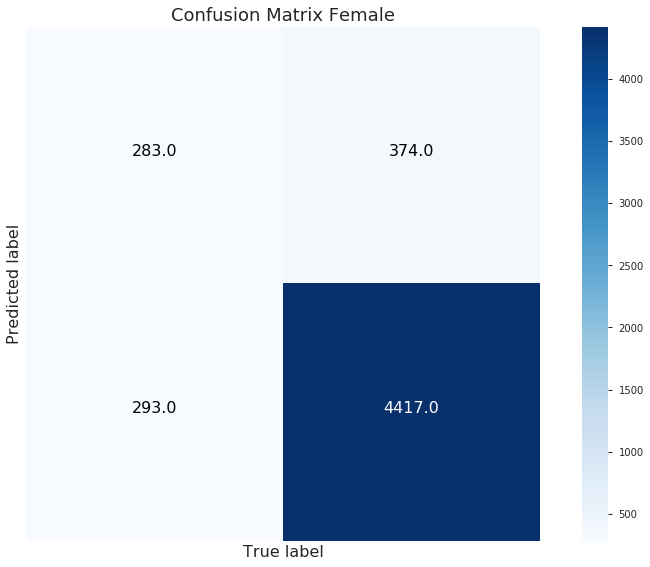

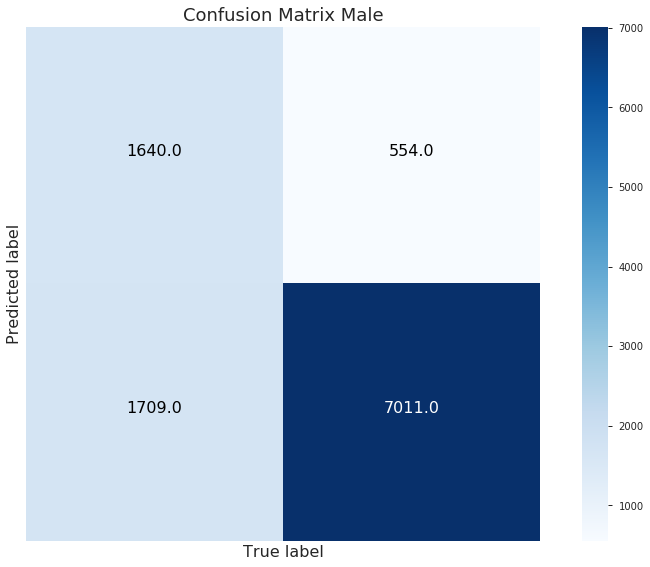

For value Female: FPR: 0.07806303485702358, FNR: 0.5086805555555556
For value Male: FPR: 0.07323198942498348, FNR: 0.5103015825619588


In [28]:
col = 'sex'
for val in  test[col].unique():
    plot_breakdown_confusion_matrix(tp, tn, fp, fn, col, val)
    
for val in test[col].unique():
    breakdown_metrics(tp, tn, fp, fn, col, val)

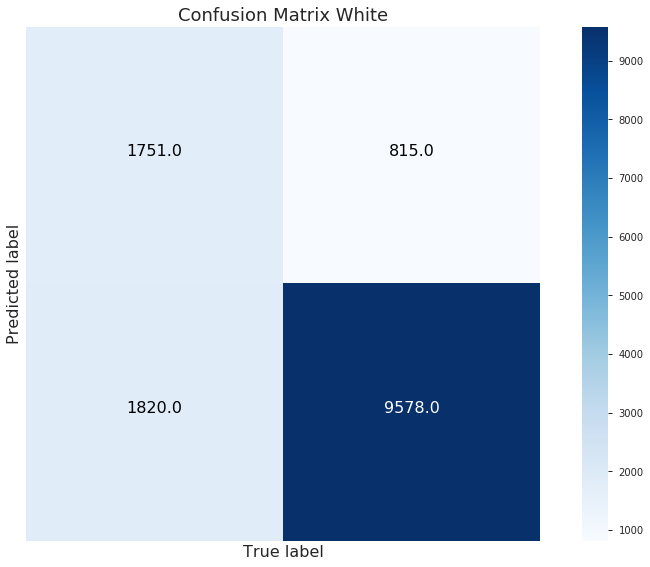

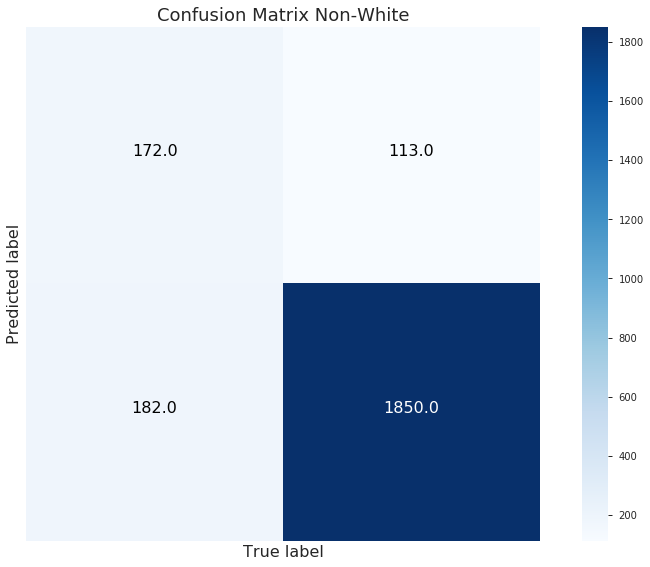

For value White: FPR: 0.07841816607331858, FNR: 0.5096611593391207
For value Non-White: FPR: 0.05756495160468671, FNR: 0.5141242937853108


In [31]:
col = 'race'
for val in  test[col].unique():
    plot_breakdown_confusion_matrix(tp, tn, fp, fn, col, val)
    
for val in test[col].unique():
    breakdown_metrics(tp, tn, fp, fn, col, val)

Privileged Group: Male
Statistical parity P(Y_hat = 1) - P(Y_hat= 1| sex=Female): 0.05269733700432823
Statistical parity P(Y_hat = 1) - P(Y_hat= 1| sex=Male): -0.02591411102274413
Statistical parity P(Y_hat = 1|sex=Male) - P(Y_hat= 1|sex=Female): 0.07861144802707236


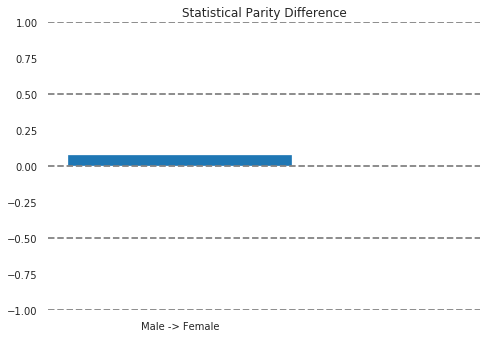

In [29]:
statistical_parity_difference(test_combined, 'predicted', 'sex')

# P(Y_hat = 1): 0.17812173699404213
# Priveleged Group: Male
# Statistical parity P(Y_hat = 1) - P(Y_hat= 1| sex=Male): -0.06180449629318702
# Statistical parity P(Y_hat = 1) - P(Y_hat= 1| sex=Female): 0.12330201661140784
# Statistical parity P(Y_hat = 1| sex=Male) - P(Y_hat= 1| sex=Female): 0.18510651290459484

Privileged Group: Male
Opportunity P(Y_hat = 1| Y=1) - P(Y_hat = 1| Y=1, sex=Female): -0.00138313871196033
Opportunity P(Y_hat = 1| Y=1) - P(Y_hat = 1| Y=1, sex=Male): 0.0002378882944428784
Statistical parity P(Y_hat = 1| Y=1, sex=Male) - P(Y_hat= 1| Y=1, sex=Female): -0.0016210270064032084


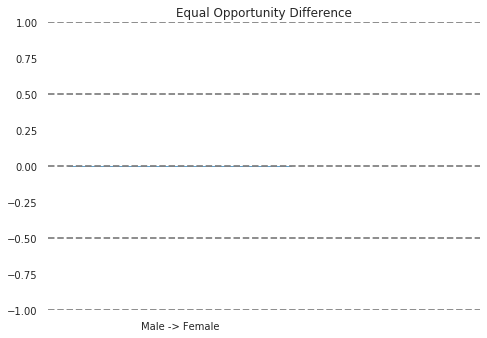

In [30]:
equality_of_opportunity(test_combined, 'predicted', 'label', 'sex')

# population level opportunity : 0.5655421066185938
# Priveleged Group: Male
# Opportunity P(Y_hat = 1| Y=1) - P(Y_hat = 1| Y=1, sex=Male): -0.030072996913683925
# Opportunity P(Y_hat = 1| Y=1) - P(Y_hat = 1| Y=1, sex=Female): 0.16487432698587262
# Statistical parity P(Y_hat = 1| Y=1, sex=Male) - P(Y_hat= 1| Y=1, sex=Female): 0.19494732389955655